# Quantum Approximate Optimization Algorithm

## Summary
* VQA for solving combinatorial problems
* Solutions for the combinatorial are encoded as quantum states 
* Apply adiabatic theorem to minimize the value of some cost Hamiltonian
* Start from the known ground state of some mixture $H_M$, then slowly evolve the parameters in the circuit, updating the cost function to converge to that of $H_C$. According to the adiabatic theorem, the system will remain in the ground state throughout this evolution, ensuring that the final quantum state measured will be the ground state of $H_C$.

**Method**
1. Define $H_C$ and $H_M$. A good choice for $H_M$ is usually the sum of Pauli X
2. Prepare the circuit:
    * Initialise the system in the g.s. of $H_M$
    * Apply alternating layers of cost and mixer Hamiltonian parameterised evolution operators
3. Measure the expectation value of $H_C$
4. Classically optimize the parameters of the evolution operators so as to minimize $\langle H_C \rangle$
---

### Codercise V.3.1.a - Building the QAOA

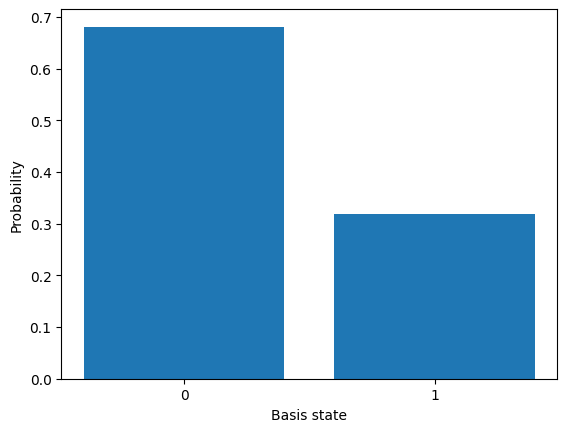

In [64]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

n_wires = 1
dev = qml.device("default.qubit", wires=n_wires)
p = 3
cost_h = qml.Hamiltonian([1], [qml.PauliZ(0)])
mixer_h = qml.Hamiltonian([1], [qml.PauliX(0)])
params = np.ones((p, 2)) * 0.5

def qaoa_layer(params):
    """Implement one QAOA layer alternating H_C and H_M.

    Args:
        params (np.array): An array with the trainable parameters of the QAOA ansatz.
        cost_h (qml.Hamiltonian): The cost Hamiltonian
    """
    qml.qaoa.cost_layer(params[0], cost_h)
    qml.qaoa.mixer_layer(params[1], mixer_h)
    

def qaoa_circuit(params, p, cost_h):
    """Implement the initial state and p layers of the QAOA ansatz.

    Args:
        params (np.array): An array with the trainable parameters of the QAOA ansatz.
        p (int): Number of layers of the QAOA ansatz.
        cost_h (qml.Hamiltonian): The cost Hamiltonian
    """
    qml.Hadamard(wires=0)
    qml.layer(qaoa_layer, p, params)


@qml.qnode(dev)
def probability_circuit(params, p, cost_h):
    """QAOA circuit which returns the probabilities.
    Args:
        params (np.array): An array with the trainable parameters of the QAOA ansatz.
        p (int): Number of layers of the QAOA ansatz.
        cost_h (qml.Hamiltonian): The cost Hamiltonian
    Returns:
        (np.tensor): A tensor with the probabilities of measuring the quantum states.
    """
    qaoa_circuit(params, p, cost_h)
    return qml.probs(wires=[0])

plt.bar(['0', '1'], probability_circuit(params,p,cost_h))
plt.xlabel('Basis state')
plt.ylabel('Probability')
plt.show()

### Codercise V.3.1.b - Building the QAOA

In [65]:
n_wires = 1
dev = qml.device("default.qubit", wires=n_wires)
p=3
cost_h=qml.Hamiltonian([1], [qml.PauliZ(0)])
mixer_h=qml.Hamiltonian([1], [qml.PauliX(0)])
params=np.ones((p, 2)) * 0.5

def optimizer(params,p,cost_h):
    """Optimizer to adjust the parameters.

    Args:
        params (np.array): An array with the trainable parameters of the QAOA ansatz.
        p (int): Number of layers of the QAOA ansatz.
        cost_h (qml.Hamiltonian): The cost Hamiltonian
        
    Returns:
        (np.array): An array with the optimized parameters of the QAOA ansatz.
    """      
    optimizer = qml.AdamOptimizer(0.1)
    steps = 100
    for _ in range(steps):
        params, _ , _ = optimizer.step(cost_function, params,p,cost_h)
    return params

@qml.qnode(dev)
def cost_function(params,p,cost_h):
    """Cost function of the QAOA circuit.
    Args:
        params (np.array): An array with the trainable parameters of the QAOA ansatz.
        p (int): Number of layers of the QAOA ansatz.

    Returns: 
        (np.tensor): A 1 dimensional tensor with the expected value of the cost Hamiltonian after applying the QAOA circuit.
    """  
    ##################
    # YOUR CODE HERE #
    ##################
    qaoa_circuit(params, p, cost_h)
    return qml.expval(cost_h)

def execute_QAOA(params,p,cost_h):
    """Execute QAOA Algorithm.
    Args:
        params (np.array): An array with the trainable parameters of the QAOA ansatz.
        p (int): Number of layers of the QAOA ansatz.
        cost_h (qml.Hamiltonian): The cost Hamiltonian

    Returns:
        (np.tensor): A tensor with the final probabilities of measuring the quantum states.
        (np.array): The optimized parameters of the QAOA.
    """  
    ##################
    # YOUR CODE HERE #
    ##################
    opt_params = optimizer(params,p,cost_h)
    probs = probability_circuit(opt_params,p,cost_h)
    return probs, opt_params
    

execute_QAOA(params,p,cost_h)

(tensor([0.68102275, 0.31897725], requires_grad=True),
 array([[0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5]]))

### Codercise V.3.2 - Ising Hamiltonian

In [80]:
# Hamiltonian test
n_particles = 3
n_wires = n_particles
h_list=[1,2,-3]

def ising_ham(n_particles):
    first_term = ["Z%d x Z%d" % (i, i+1) for i in range(n_particles-1)] + ["Z%d x Z%d" % (n_particles-1, 0)]
    
    second_term = ["h%d Z%d" % (i, i) for i in range(n_particles)]
    coeffs = [-1 for _ in range(len(first_term + second_term))]
    
    return zip(coeffs, first_term + second_term)
    
list(ising_ham(n_particles))
    

[(-1, 'Z0 x Z1'),
 (-1, 'Z1 x Z2'),
 (-1, 'Z2 x Z0'),
 (-1, 'h0 Z0'),
 (-1, 'h1 Z1'),
 (-1, 'h2 Z2')]

In [92]:
n_particles = 3
n_wires = n_particles
h_list=[1,2,-3]
# Define the mixer Hamiltonian
mixer_h = qml.Hamiltonian([1.0] * n_wires, [qml.PauliX(i) for i in range(n_wires)])
# Define number of layers and initial parameters
p=5
params=np.ones((p, 2)) * 0.5

def build_cost_ising(n_particles, h_list):
    """Function to build the cost Hamiltonian of the Longitudinal Ising problem.
    
    Args:
        n_particles (int): Number of particles to be considered in the Hamiltonian.
        h_list (list[float]): List of magnetic field values for each particle.
        
    Returns:
        (qml.Hamiltonian): The cost Hamiltonian of the Longitudinal Ising model.
    """
    ##################
    # YOUR CODE HERE #
    ##################
    first_term = [qml.PauliZ(i) @ qml.PauliZ(i+1) for i in range(n_particles-1)] + [qml.PauliZ(n_particles-1) @ qml.PauliZ(0)]
    second_term = [qml.PauliZ(i) for i in range(n_particles)]
    coeffs = [-1 for _ in range(len(first_term))] + [-1*h_list[i] for i in range(len(second_term))]
    return qml.Hamiltonian(coeffs, first_term + second_term)


def QAOA_ising(params,p,cost_h):
    """QAOA Algorithm to solve the Longitudinal Ising problem.
    Args:
        params (np.array): an array with the trainable parameters of the QAOA ansatz.
        p (int): number of layers of the QAOA ansatz.
        cost_h (qml.Hamiltonian): the cost Hamiltonian.
        
    Returns:
        (np.tensor): a tensor with the final probabilities of measuring the quantum states.
        (np.array): the optimized parameters of the QAOA.
    """  
    ##################
    # YOUR CODE HERE #
    ##################
    opt_params = optimizer(params,p,cost_h)
    probs = probability_circuit(opt_params,p,cost_h)
    return probs, opt_params
